# Time series prediction (Part 2 - 1.5 day)

**NB objectives**
- [ ] Get to use few prediction models
- [ ] Understand what CV is for

**Required librairies**
- [ ] matplotlib
- [ ] numpy
- [ ] pandas
- [ ] seaborn
- [ ] pmdarima

## Prediction models

ARIMA est un modèle statistique pour les séries temporelles, tout comme la régression linéaire est un modèle utilisé en machine learning. Il fonctionne bien pour des ensembles de données simples qui suivent des contraintes spécifiques et lorsque vous n'avez pas suffisamment de données pour entraîner un modèle de deep learning. Découvrons la prédiction sur séries temporelles et certains concepts mathématiques avec ARIMA. 

Tout au long de ce cahier, consultez et revenez régulièrement la documentation du package pdmarima. Elle contient beaucoup d'informations utiles.
Reference: http://alkaline-ml.com/pmdarima/#

### ARIMA (in French)

#### La théorie

Le modèle ARMA (AutoRegressive Moving Average, ou autorégressif et moyenne mobile en français), est un modèle adapté aux prédictions sur toute série temporelle dont la valeur $Y$ à l'instant $t$ peut s'expliquer par les valeurs précédentes et les perturbations (bruits) précédentes.

Avant de préciser ce qu'est un jeu de donnée suivant le modèle ARIMA, précisons un jeu de donnée suivant les conditions :  

##### **Autoregressif** :

le modèle peut prédire $Y$ à l'instant $t$, notée $Y_t$, à partir des valeurs précédentes de $Y$ selon un modèle de regression linéaire, c'est à dire $Y_{t-1}, Y_{t-2}, ..., Y_0$. On note $p$ le nombre de composantes utilisées pour prédire $Y_t$, avec

> $Y_t = \sum_{i=1}^p \varphi_i\,Y_{t-i} + \varepsilon_t + c$, avec $\varepsilon_t$ une perturbation, et c une constante.

En résumé, cela signifie que la dernière valeur dépend des valeurs précédentes, que la valeur d'aujourd'hui dépend des valeurs d'hier.

##### **Moyenne mobile**:

Le modèle peut prédire la valeur $Y_t$ à partir de ses erreurs précédentes entre ses prédictions et les données réelles. Pour un modèle avec une moyenne mobile d'ordre $q$, on peut exprimer $Y_t$ de la façon suivante :

> $Y_t = \mu + \varepsilon_t + \sum_{1}^{q}\theta_q\varepsilon_{t-q}$, avec $\mu$ une constante.

**ATTENTION** rien à voir avec la moyenne mobile habituelle d'un signal temporel, comme `pd.rolling()`.

En résumé, cela signifie que le modèle essaie de coller au mieux les données du passé, mais peut faire des erreurs de variance. C'est à dire que le modèle est bon en moyenne au cours du temps, mais le signal présente du bruit autour de cette moyenne "mobile". Le modèle incorpore alors cette "variation" dans sa prédiction pour être plus juste.

##### **Intégré** :

Un modèle ARMA est adapté à des jeux de données stationnaires, c'est à dire avec une moyenne et un écart type fixe au cours du temps. Il est rare que l'on observe de telles données. De nombreux jeux de données de séries temporelles présentent des tendances sur la moyenne ou encore des saisonnalités. Pour cela, il convient de stationnariser dans un premier temps le problème. On parle **d'intégration**. Un modèle **ARIMA** est dit :

L'intégration signifie que l'on peut corriger le jeu de donnée en réalisant le modèle sur $Y'_t = Y_t - Y_{t-1}$ pour une correction d'ordre 1 (d=1) ou encore $Y''_t = Y_t - Y_{t-1} - Y_{t-2}$ pour une correction d'ordre 2 (d=2), etc...  On note $d$ l'ordre de *correction par intégration* permet de supprimer les tendances polynomiales d'ordre $d$, avec:
    
> $Ycorr_t = Y_t - \sum_{1}^{d} Y_{t-d}$

Les modèles ARIMA sont souvent notés : ARIMA(p, d, q), soit **ARIMA(2, 1, 1)** signifie :
- un modèle autoregressif d'ordre 2,
- sur des données intégrées 1 fois,
- et avec une moyenne mobile d'ordre 1.

#### En définitive:

Tout modèle ARIMA est optimisé sur la base de ces trois hypothèses: *AR*, *MA* et *I*, c'est à dire qu'il est autoregressif, respecte les conditions de la moyenne mobile, et peut être stationnaire par intégration.

Le modèle est souvent optimisé à l'aide de la méthode des moindres carrées.

Vous n'avez rien compris ? Tant pis ! Pratiquons pour rendre les choses plus évidentes.  
Si vous êtes mathématicien, aidez vos camarades et l'animateur. 

### Bit of practice

#### Discover and prepare data

1. load the data then reply and plot it.
2. Is this time serie stationary or not?
3. What is its tendancy?
4. What about heteroskedasticity?

Reply below your figures.

In [4]:
#Import required packages (to be implemented if required)
from pandas import date_range
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pmdarima.datasets import load_airpassengers

In [6]:
START_DATE = '1949-01-01'
airline = load_airpassengers(as_series=True)
#there's no datetimeindex from the bundled dataset. So let's add one.
airline.index= date_range(START_DATE, periods=len(airline), freq='MS')

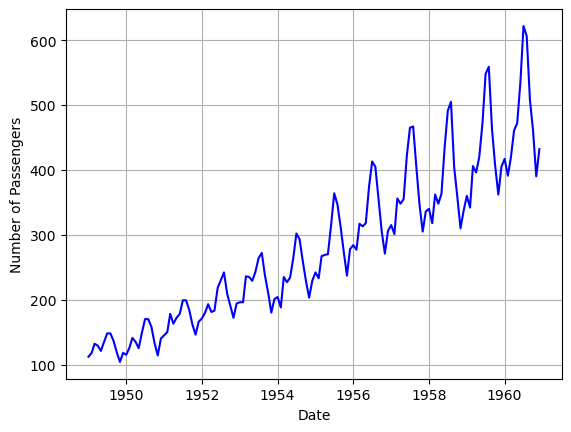

In [12]:
sns.lineplot(airline, color='blue')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.grid(True);

In [14]:
from pmdarima.arima import decompose
from pmdarima.utils import decomposed_plot

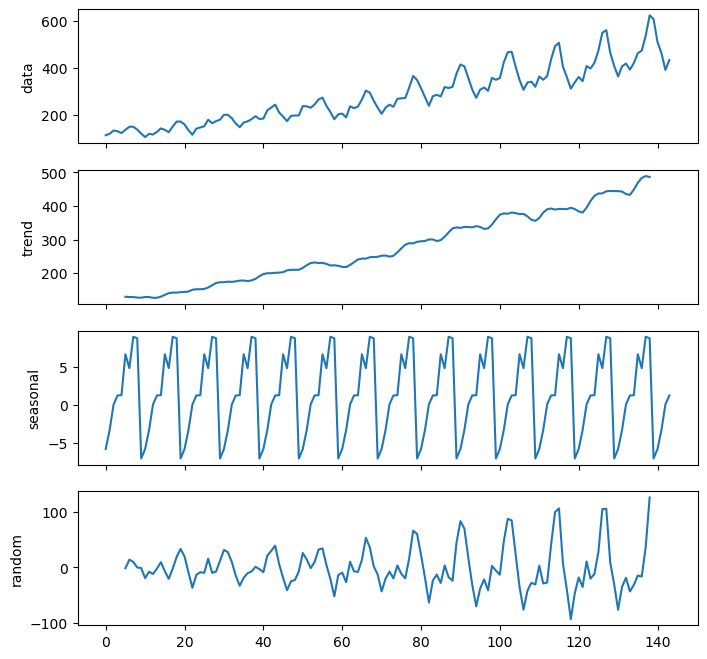

In [28]:
decomposed = decompose(airline.values, 'additive', 10)
plot = decomposed_plot(decomposed, {'figsize': (8,8)})

In [38]:
# lets do a test for stationarity
from statsmodels.tsa.stattools import adfuller

def adf_test(series, title=''):
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['ADF Statistic', 'p-value', '# Lags Used', '# Observations']
    for value, label in zip(result, labels):
        print(f'{label}: {value}')
    if result[1] <= 0.05:
        print("=> The series is stationary.")
    else:
        print("=> The series is non-stationary.")

adf_test(airline, title='Values')

Augmented Dickey-Fuller Test: Values
ADF Statistic: 0.8153688792060457
p-value: 0.991880243437641
# Lags Used: 13
# Observations: 130
=> The series is non-stationary.


### Reply

the data is not stationary,

the tendency is almost perfect linear positive,

for heteroskedaity i can say that it exists here

`reply here`

#### Stationarity and integration (*d*) of the data

Do not forget, ARIMA works only with stationary data. If a signal is not stationary, particulary if it has not a stable mean, you could integrate it.

Remind that to integrate a signal mean to look at the difference $Y'_t = Y_t - Y_{t-1}$ and not $Y_t$ anymore.

1. look at the signal $Y_t - Y_{t-1}$
1. What about the stationarity?
1. Propose a process to prove visually or statistically that the signal is or not stationary.
4. What about the variance and how to deal with it with? What is the mathematical function that can do the job?
5. What is the proper value for *d* to build the ARIMA model?

Reply below your figures

In [41]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

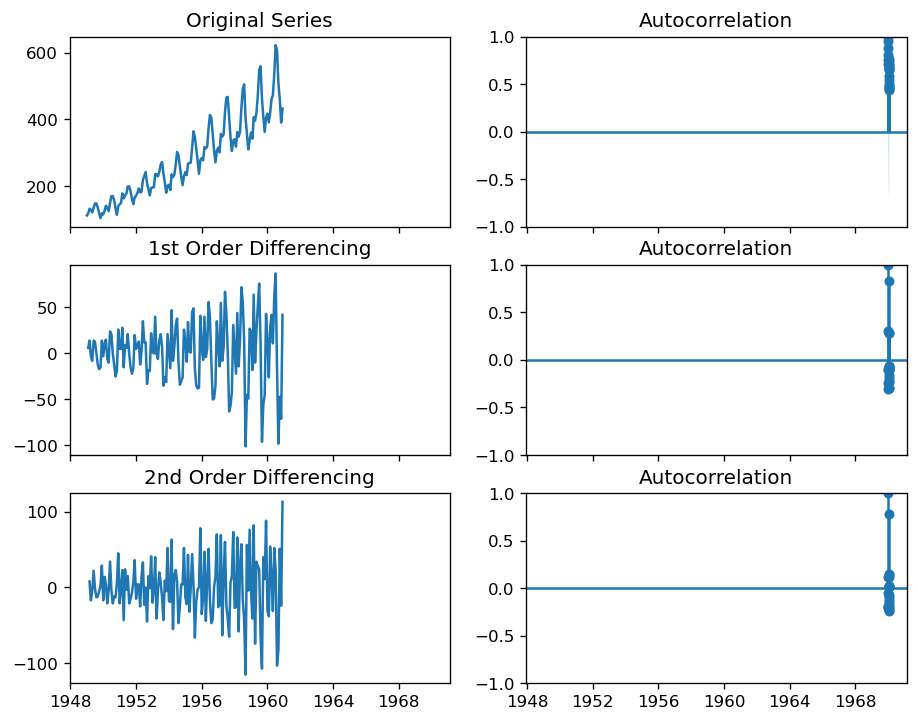

In [46]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(airline); axes[0, 0].set_title('Original Series')
plot_acf(airline, ax=axes[0, 1])

axes[1, 0].plot(airline.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(airline.diff().dropna(), ax=axes[1, 1])

axes[2, 0].plot(airline.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(airline.diff().diff().dropna(), ax=axes[2, 1])
plt.show()

In [53]:
adf_test(airline.diff().diff(), title='Values')

Augmented Dickey-Fuller Test: Values
ADF Statistic: -16.384231542468502
p-value: 2.7328918500142026e-29
# Lags Used: 11
# Observations: 130
=> The series is stationary.


In [ ]:
# your code for the figure

`reply here`

#### Train/Test split challenges

Same as one classical machine learning problem, you should put yourself in the position where you are the most closed to the production context. That means you should create a dataset without touching it. So, realize a train / test split.

The way we split the data for time series is different than the non TS data.

1. Explain how you have to do the train/test split for TS.
2. Explain why a complete random split is a nosense for TS.
3. write the code to apply the proper train/test TS split.

In [56]:
def ts_train_test_split(data, split_date):
    split_index = data.reset_index()[data.reset_index()['index'] == split_date].index[0]
    train = data[:split_index]
    return data[:split_index], data[split_index:]

In [60]:
# Hold back the last twelve months as a TEST set
train, test = ts_train_test_split(airline / airline.index.days_in_month, '1959-01-01')

In [62]:
train.shape, test.shape

((120,), (24,))

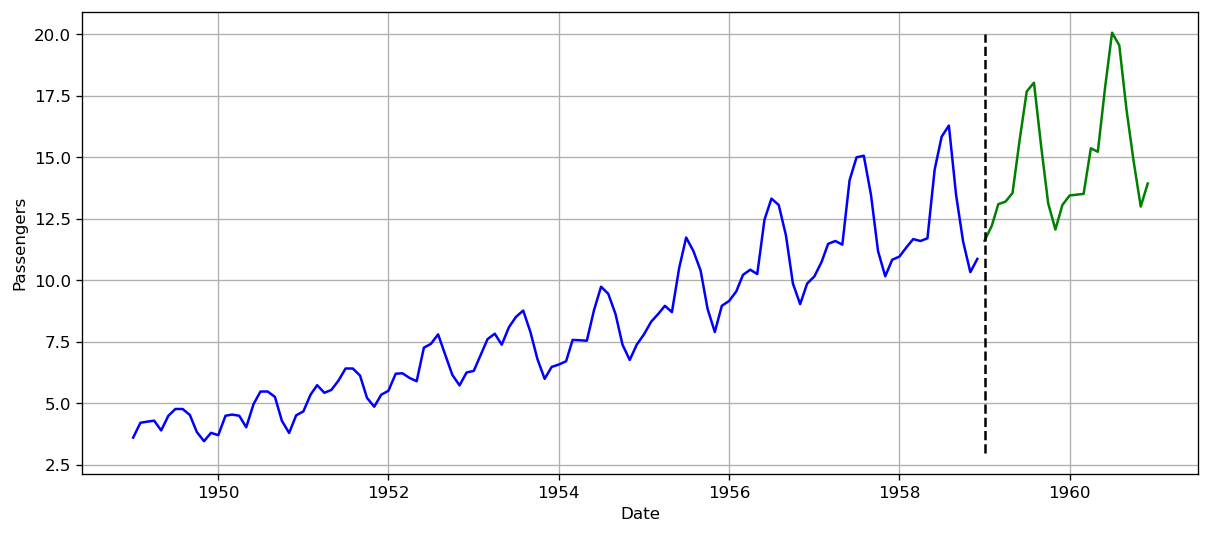

In [73]:
# Plot train and test sets
plt.figure(figsize=(12,5))
sns.lineplot(train, color='blue')
sns.lineplot(test, color='green')
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.vlines(x=test.index[0],ymin=3, ymax=20, color='black', ls='--');

#### Déterminer P et Q

Afin de valider les paramètres $p$ (*AR*) et $q$ (*MA*) du modèle ARIMA, on peut calculer l'auto-corrélation des données temporelles.
- Pour déterminer $p$ nous utiliserons l'autocorrelation des données par une donnée passée avec un décalage temporel (appelé *lag* en anglais). On utilisera pour cela la PACF (*Partial Auto Correlation Function*). La fonction PACF cherche à déterminer la correlation entre les données $Y_t$ et $Y_{t-i}$. La valeur de $p$ est déterminée par $PACF_i \approx 0$  
- pour déterminer $q$, on utilisera l'ACF (*Auto Correlation Function*). La fonction ACF calcule la correlation entre la série temporelle et elle-même avec un décalage temporel. Soit calculer la correlation de $Y_(t, t-1, ...)$ avec $Y_(t-i, t-i-1, ...)$.


To validate the parameters $p$ (AR) and $q$ (MA) of the ARIMA model, one can compute the autocorrelation of the time series data.
- To determine $p$, we will use the autocorrelation of the data against a lagged version of itself. For this purpose, we will use the PACF (Partial Auto Correlation Function). The PACF seeks to determine the correlation between the data $Y_t$ and $Y_{t-i}$. The value of $p$ is determined by $PACF_i \approx 0$.
- To determine $q$, we will use the ACF (Auto Correlation Function). The ACF calculates the correlation between the time series and itself at a lagged time. This means calculating the correlation of $Y_{(t, t-1, ...)}$ with $Y_{(t-i, t-i-1, ...)}$.

Answer the questions:
1. Look at the documentation of pdmarima for acf and pacf.
2. Can you explain what you observe on this data? What means the value? If there is kind of periodicity, what does it means? Reply below your figures.
3. Create a figure with the ACF and the PACF for the data with explaination. Do it with Paint or something else to do it fast.
4. From your observation, what should be the parameter P, I and Q of the ARIMA model? Reply below your figures.

In [76]:
airline_stationary = airline.diff().diff()

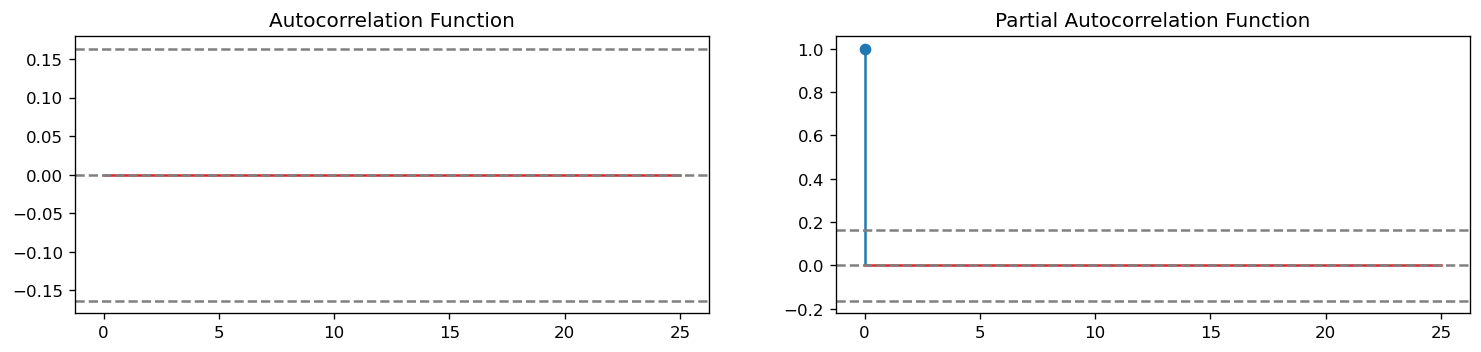

In [78]:
# ACF & PACF plots
from pmdarima.utils import acf, pacf
import matplotlib.pyplot as plt
import numpy as np

your_stationary_data =  airline_stationary 
n_sample = len(your_stationary_data)
lag_acf = acf(your_stationary_data, nlags=25)
lag_pacf = pacf(your_stationary_data, nlags=25)

pct_95 = 1.96/np.sqrt(n_sample)

plt.figure(figsize=(15, 3))
# Plot ACF:
plt.subplot(121)
plt.stem(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-pct_95, linestyle='--', color='gray')
plt.axhline(y=pct_95, linestyle='--', color='gray')
# plt.axvline(x=q, color='black', linestyle='--', label=f'q={q}')
# plt.legend()
plt.title('Autocorrelation Function')            

# Plot PACF
plt.subplot(122)
plt.stem(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-pct_95, linestyle='--', color='gray') # represent 95 % of a gaussian data
plt.axhline(y=pct_95, linestyle='--', color='gray') # represente 95 % of a gaussian data
# plt.axvline(x=p, color='black', linestyle='--', label=f'p={p}')
plt.title('Partial Autocorrelation Function')
# plt.legend()
plt.show()

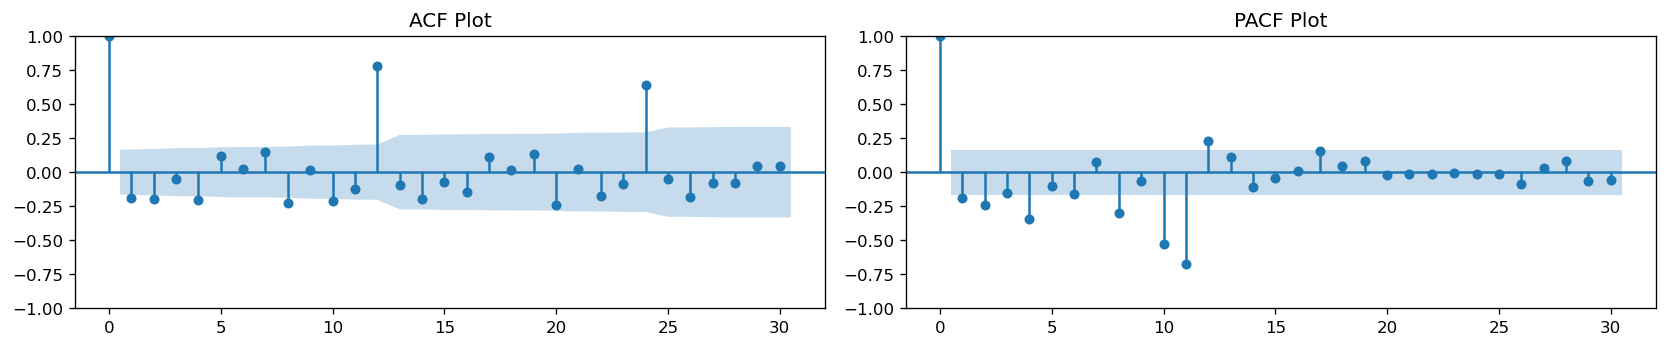

In [83]:
plt.figure(figsize=(14,3))

plt.subplot(121)
plot_acf(airline.diff().diff().dropna(), lags=30, ax=plt.gca())
plt.title('ACF Plot')

plt.subplot(122)
plot_pacf(airline.diff().diff().dropna(), lags=30, ax=plt.gca())
plt.title('PACF Plot')

plt.tight_layout()
plt.show()

# `reply here`

d = 2 (2 differencing were used)

q = 3 (ACF plot)

p = 0 (Pacf show one significant peak at 0)



## Your first ARIMA model

### Train and evaluate your model

1. Create your ARIMA model with pdmarima framework.
1. Train your model with proper treatment.
1. Create a plot with the original data and the prediction for test. Share your observation.
1. Evaluate your model with the good metric. Justify your choice!

In [99]:
# your code here
from pmdarima.arima import ARIMA

In [102]:
p, d, q = 0, 2, 3

In [342]:
model_1 = ARIMA((p,d,q))

In [354]:
model_1_fit = model_1.fit(train)
print(model_1_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  120
Model:               SARIMAX(0, 2, 3)   Log Likelihood                -139.272
Date:                Wed, 09 Oct 2024   AIC                            288.544
Time:                        16:36:42   BIC                            302.397
Sample:                    01-01-1949   HQIC                           294.169
                         - 12-01-1958                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0006      0.005     -0.125      0.901      -0.011       0.009
ma.L1         -0.4786      4.615     -0.104      0.917      -9.524       8.567
ma.L2         -0.3403      2.448     -0.139      0.8

In [356]:
model_1_fit.fittedvalues()

1949-01-01    -0.000641
1949-02-01     5.418393
1949-03-01     4.815027
1949-04-01     4.404023
1949-05-01     4.467508
                ...    
1958-08-01    16.313680
1958-09-01    16.323906
1958-10-01    12.023898
1958-11-01    10.866817
1958-12-01     9.996919
Freq: MS, Length: 120, dtype: float64

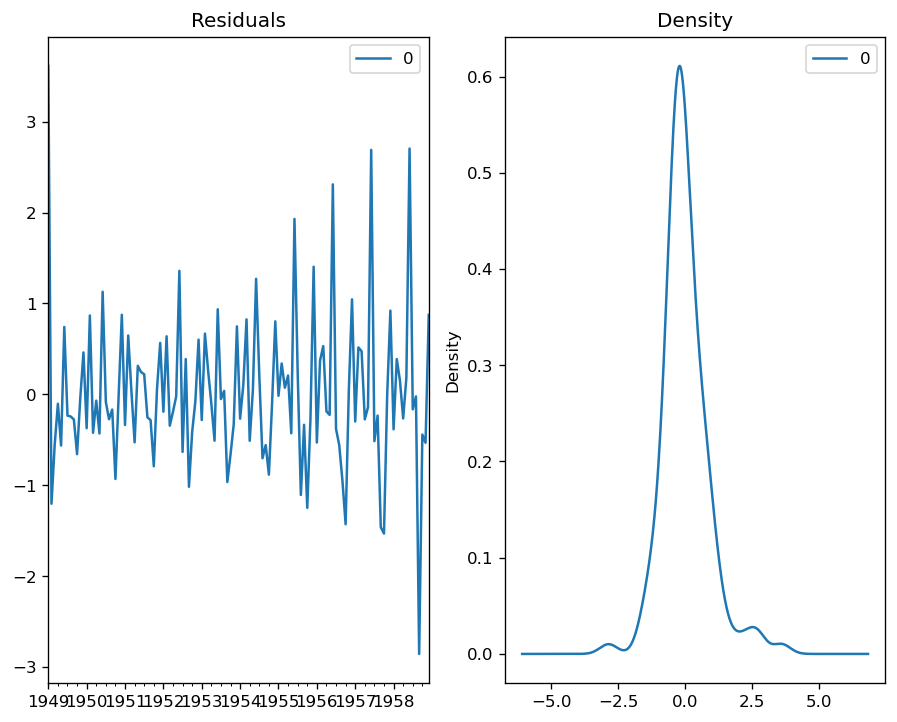

In [358]:
residuals = pd.DataFrame(model_1_fit.resid())
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1]);

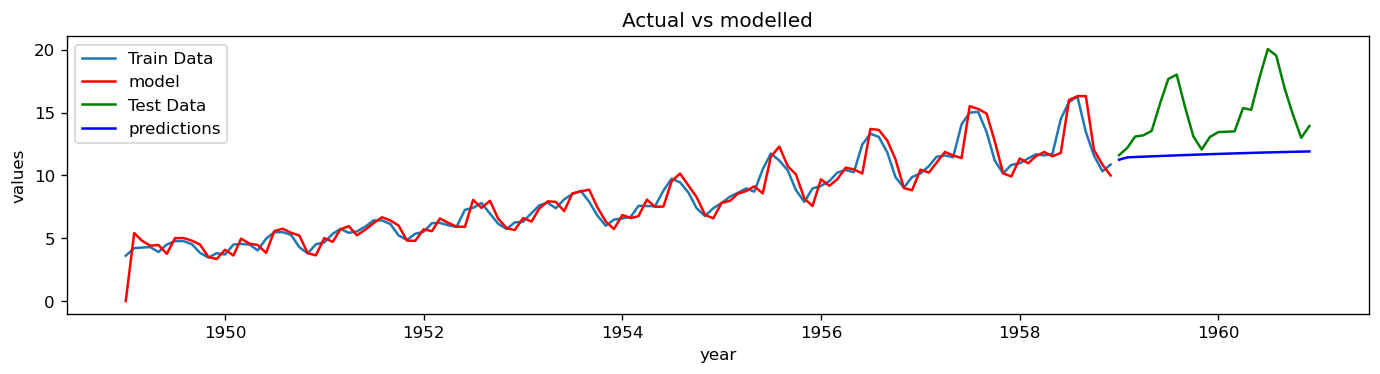

In [360]:
plt.figure(figsize=(14,3))
plt.plot(train.index, train, label='Train Data')
plt.plot(model_1_fit.fittedvalues().index, model_1_fit.fittedvalues(), label='model', color='red')
plt.plot(test.index, test, label='Test Data', color='green')
plt.plot(model_1.predict(24).index, model_1.predict(24), label = 'predictions', color='blue')
plt.legend()
plt.title('Actual vs modelled')
plt.xlabel('year')
plt.ylabel('values')
plt.show()

In [175]:
from pmdarima import auto_arima

In [177]:
model = auto_arima(train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=292.488, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=860.154, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=713.603, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=292.969, Time=0.25 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=290.897, Time=0.16 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.36 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=288.600, Time=0.29 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=289.114, Time=0.36 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=281.598, Time=0.66 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=281.959, Time=0.38 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=inf, Time=0.81 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=280.318, Time=0.79 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=282.026, Time=0.67 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=277.193, Time=0.7

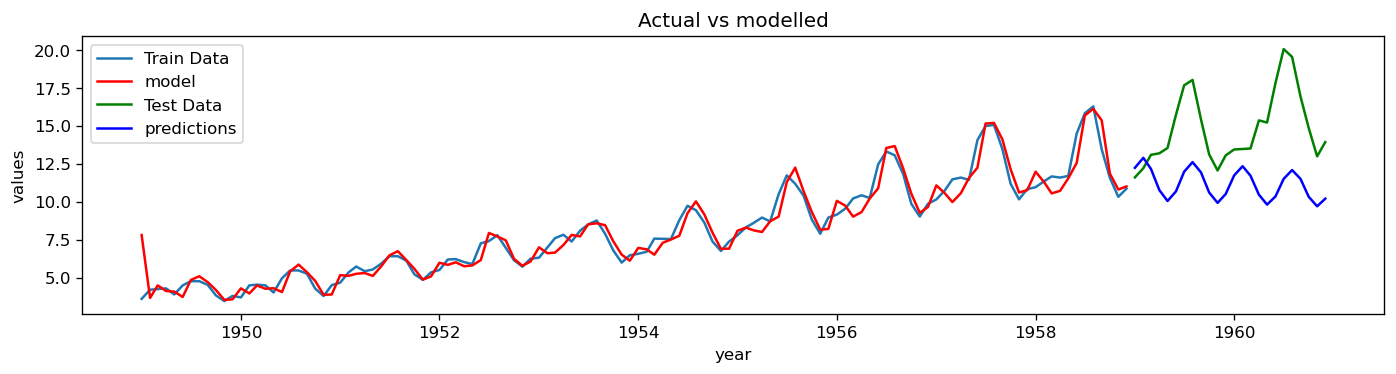

In [181]:
plt.figure(figsize=(14,3))
plt.plot(train.index, train, label='Train Data')
plt.plot(model.fittedvalues().index, model.fittedvalues(), label='model', color='red')
plt.plot(test.index, test, label='Test Data', color='green')
plt.plot(model.predict(24).index, model.predict(24), label = 'predictions', color='blue')
plt.legend()
plt.title('Actual vs modelled')
plt.xlabel('year')
plt.ylabel('values')
plt.show()

In [410]:
model_sarima = auto_arima(train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=12,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True, 
                      start_P=0, 
                      D=None, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True,
                      trend='t',
                      with_intercept=True,
                      random=True,
                      n_fits= 10
                         )

print(model_sarima.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12] intercept   : AIC=70.874, Time=0.70 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=71.828, Time=0.14 sec
 ARIMA(1,1,0)(1,1,0)[12] intercept   : AIC=69.060, Time=0.92 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=69.697, Time=0.57 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=71.828, Time=0.14 sec
 ARIMA(1,1,0)(0,1,0)[12] intercept   : AIC=67.914, Time=0.21 sec
 ARIMA(1,1,0)(0,1,1)[12] intercept   : AIC=69.265, Time=0.50 sec
 ARIMA(1,1,0)(1,1,1)[12] intercept   : AIC=71.464, Time=0.73 sec
 ARIMA(2,1,0)(0,1,0)[12] intercept   : AIC=69.702, Time=0.29 sec
 ARIMA(1,1,1)(0,1,0)[12] intercept   : AIC=69.562, Time=0.39 sec
 ARIMA(0,1,1)(0,1,0)[12] intercept   : AIC=68.326, Time=0.25 sec
 ARIMA(2,1,1)(0,1,0)[12] intercept   : AIC=71.551, Time=0.83 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=67.914, Time=0.22 sec

Best model:  ARIMA(1,1,0)(0,1,0)[12] intercept
Total fit time: 5.941 seconds
                                  

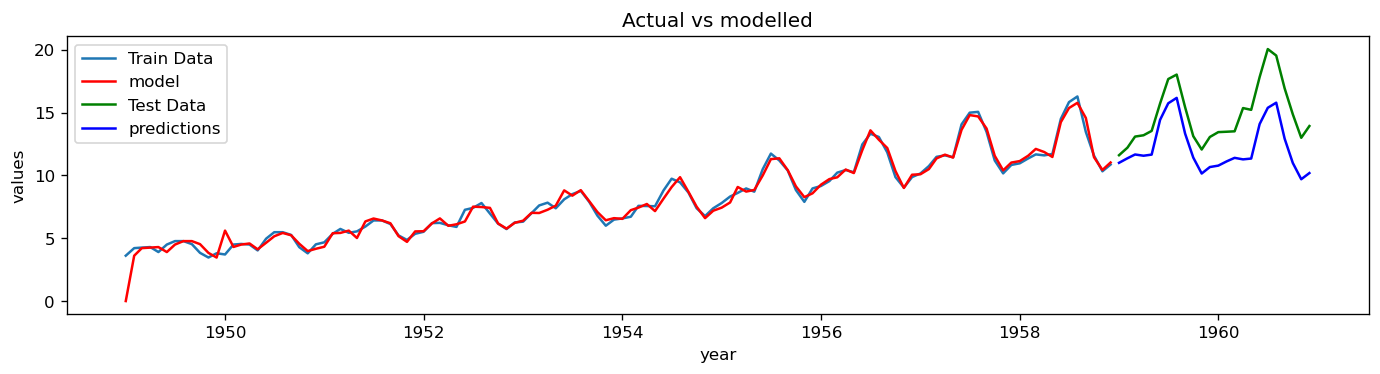

In [412]:
plt.figure(figsize=(14,3))
plt.plot(train.index, train, label='Train Data')
plt.plot(model_sarima.fittedvalues().index, model_sarima.fittedvalues(), label='model', color='red')
plt.plot(test.index, test, label='Test Data', color='green')
plt.plot(model_sarima.predict(24).index, model_sarima.predict(24), label = 'predictions', color='blue')
plt.legend()
plt.title('Actual vs modelled')
plt.xlabel('year')
plt.ylabel('values')
plt.show()

In [414]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(test, model_sarima.predict(24))
mse = mean_squared_error(test, model_sarima.predict(24))
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test - model_sarima.predict(24)) / test)) * 100

print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"Mean Squared Error (MSE): {mse:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.3f}%")

Mean Absolute Error (MAE): 2.575
Mean Squared Error (MSE): 7.904
Root Mean Squared Error (RMSE): 2.811
Mean Absolute Percentage Error (MAPE): 17.084%


**Observations / Conclusion**:  
`write here`

### Cross-validation with ARIMA

1. Use the documentation of pdmarima to realize the CV and get the CV score.
2. What are the hyperparameters? What are their impacts?

In [298]:
# your code here
from pmdarima.model_selection import SlidingWindowForecastCV, cross_val_score

In [330]:
cv = SlidingWindowForecastCV(window_size=80, step=10, h=1)

In [416]:
model_sarima_cv_scores = cross_val_score(model_sarima, train, scoring='smape', cv=cv, verbose=2)

[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................


In [418]:
print("Model_sarima CV scores: {}".format(model_sarima_cv_scores.tolist()))

Model_sarima CV scores: [0.9055013364047569, 2.3614151873946825, 0.03276933226999403, 3.5207343815959327]


In [420]:
sarima_average_error = np.average(model_sarima_cv_scores)
sarima_average_error

1.7051050594163417

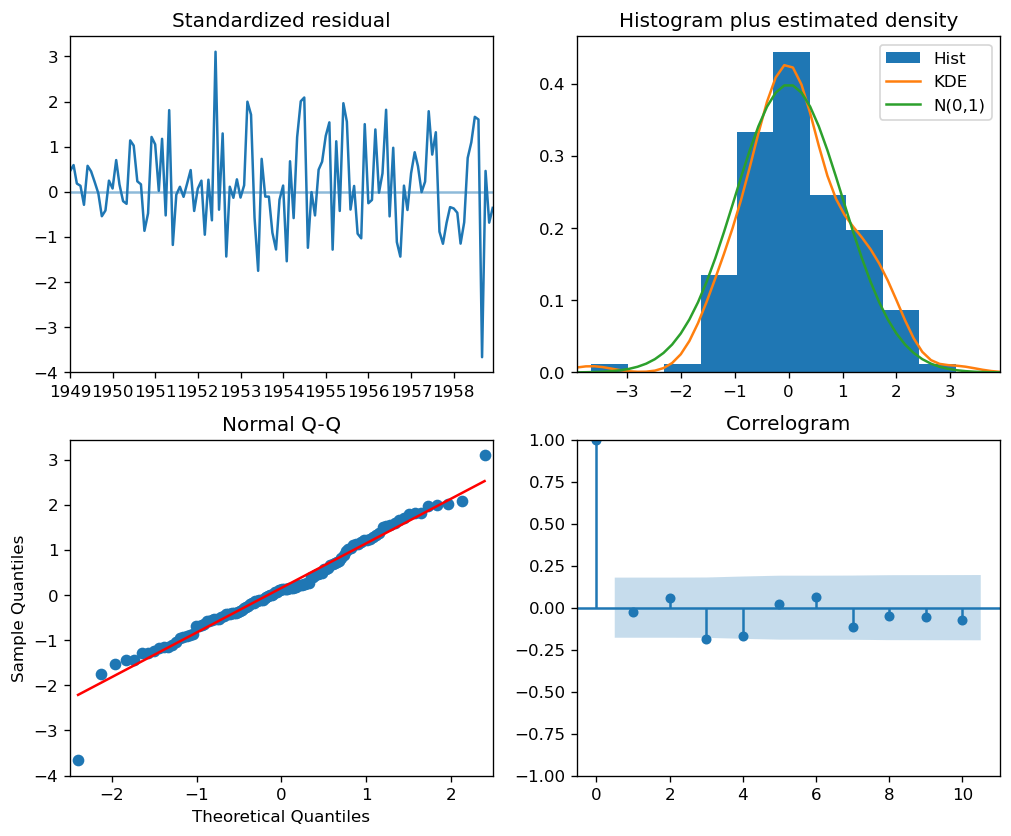

In [338]:
model_sarima.plot_diagnostics(figsize=(10,8));

**Observations / Conclusion**:  
`write here`